# Sparkify - Churn Prediction with PySpark


## 1. Introduction

### Business Context
Sparkify is a fictitious music streaming service, created by Udacity to mimic the datasets generated by companies such as Spotify or Pandora. Millions of users play their favorite songs through such services on a daily basis, either through free tier that plays advertisements, or by using a premium subscription model which offers additional functionalities and is typicaly ad-free. Users can upgrade or downgrade their service any time, but also cancel it altogether, so it is very important to make sure the users like the service. Every time a user interacts with the service, whether playing songs, adding them to playlists, rating them with the thumbs down/up, adding a friend, logging in or out, changing settings, data is generated. All this logs contain key insights for helping the business understand whether the users are happy with the service.

In order to make sure the business stays on track with its (financial) goals, it is key to identify the users that are likely to churn, i.e. users who are at risk of downgrading from premium to free tier, or cancelling the service altogether. If businesses can accurately identify these users in advance before they leave they can offer them discounts and other similar incentives and save millions in revenues. It is a well known fact that it is more expensive to acquire a new customer than it is to retain an existing one.

### Project Overview
The aim of this project is to build and train a supervised machine learning model that would be able to accurately identify users who are likely to cancel the music streaming service (in both free and paid tier), based on the information contained in the user activity logs recorded within a given observation window. The data used for training is the simulated Sparkify activity data provided by Udacity. The project is carried out by leveraging the Apache Spark distributed cluster-computing framework capabilities, through Python API for Spark, PySpark. The initial stages of model development (data understanding, exploratory analysis, also model selection) are performed on a smaller dataset using Spark in local mode, whereas the entire Sparkify dataset is too big to be processed locally and therefore an Elastic MapReduce (EMR) cluster has been deployed on the AWS cloud to train the selected models.

The project consists of three main steps that can be summarized as follows:

**Data Understanding**
- loading the dataset 
- inferring the meaning of different variables, their type, the values they can take, their distribution
- understanding the relationship between different columns
- identifying missing values, potential duplicates

**Feature Engineering and Exploratory Data Analysis**
- transforming the original dataset (one row per user log) to a dataset with per-user (one row per user) information or statistics, obtained through mapping (e.g. user's gender, length of observation period, most recent subscription level, etc.) or log aggregation (e.g. song/advertisement/thumbs up/home page count) 
- engineering the features that will be used to identify churned users, e.g. aggregated statistic per unit of time, number of plan changes, songs played vs. total activity ratio, thumbs up vs. thumbs down ratio, activity trend, etc.
- analyzing the correlation between engineered features
- defining and calculating the binary response variable: __1__ - users who cancelled their subscription within the observation period, and **0** - users who kept the service throughout
- performing exploratory data analysis comparing the engineered statistics for users who stayed vs users who churned

**Modelling and Evaluation**
- defining a pipeline that scales the numeric features, combines all features in the right format and fits a selected binary classifier (logistic regression, random forest classifier and gradient boosting classifier have been used)
- splitting the dataset into train and test set
- model tuning using grid-search with cross validation for all different classifiers on the training data (using the smaller Sparkify dataset in Spark local mode)
- evaluating model performance in cross validation, and analyzing feature importances
- retraining the models that performed best on the small Sparkify dataset also on the EMR cluster
- evaluating model performance on the test set

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround

from pyspark.sql.types import IntegerType, DateType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator

In [2]:
# Create a Spark Session
spark = SparkSession \
.builder \
.appName('Sparkify') \
.getOrCreate()

In [3]:
# Check Spark configuration
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '1f6c4f8bdf4a'),
 ('spark.driver.port', '43539'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1565683446619'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

## 2. Data Understanding

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). This workspace is used to build the project, and to explore a smaller subset with Spark before deploying your cluster on the cloud.

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.

In [4]:
# Load data and store it into a Spark dataframe
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [5]:
# Structure of the dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [44]:
# Column types 
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [7]:
# Shape of the dataframe
nrows = df.count()
ncols = len(df.dtypes)
print(f'The imported dataframe has {nrows} rows and {ncols} columns.')

The imported dataframe has 286500 rows and 18 columns.


In [8]:
# Potential duplicate entries
nduplicates = df.count() - df.dropDuplicates().count()
print(f'There are {nduplicates} duplicate rows.')

There are 0 duplicate rows.


In [9]:
# Print first row to get the idea of the dataframe
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

#### About the Dataframe
The dataframe is a user log of user interacations. All the below analytics were calculated using the smaller data set


User-level features, such as first name, last name, location, and the agent used for the log recorded are assumed to not contain information that could distinguish people who are likely to cancel and those 

The dataframe includes 18 columns:
- __artist__ (string): artist name, approx 18 thousand different artists, null for log events where no music is being played
- __auth__ (string): current authentication/authorization, 4 categories ("Logged In", "Logged Out", "Cancelled", "Guest")

(Note: "logged out" and "guest" logs have almost all other column values to null (the ones about the user), "cancelled" corresponds to cancel confirmation page; one can obtain user information from "logged out" based on the session id)
- __firstName__ (string): user's first name
- __gender__ (string): user's gender, 2 categories ("M" and "F")
- __itemInSession__ ('bigint'): item order in a given session
- __lastName__ (string): user's last name
- __length__ (double): song's length in seconds
- __level__ (string): tier, 2 categories 'free' or 'paid'
- __location__ (string): user's location
- __method__ (string): 2 categories 'GET' or 'PUT' also about page items
- __page__ (string): log of the type of page that is open, categorical variable with more than 20 categories, see below
- __registration__ (bigint): timestamp of user's registration
- __sessionId__ (bigint): session identifier
Can be same number for multiple users
- __song__ (string): song name
- __status__ (bigint): 200, 307 or 404, categorical 404 corresponds to error in page, 307 to other page categories, see below
- __ts__ (bigint): timestamp of a specific event
- __userAgent__ (string): agent used by the user to access streaming service - in this dataset fixed for a specific user (no cases of users with different user agents?check), 57 different categories
- __userId__ (string): user identifier

In [9]:
# Convert the timestamps in columns 'registration' and 'ts' into date&time
df = df.withColumn('registrationDate', (df['registration']/1000).cast(TimestampType()))
df = df.withColumn('tsDate', (df['ts']/1000).cast(TimestampType()))

In [11]:
df.where(df.registration.isNull()).count()

8346

In [227]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', registrationDate=datetime.datetime(2018, 9, 28, 22, 22, 42), tsDate=datetime.datetime(2018, 10, 1, 0, 1, 57))

In [12]:
# Explore the artist column
df.groupby('artist').count().sort('count', ascending = False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|58392|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



In [229]:
# Inspect whether there are empty strings in the artist column
df.where(df.artist == " ").count()

0

In [230]:
# Null in the artist column represents logs where a song is not being played (All page categories except NextSong)
df.where(df.artist.isNotNull()).groupby('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



In [231]:
# Number of different artists (-1 for the null that corresponds to logs where no songs were played)
df.select('artist').dropDuplicates().count() - 1

17655

In [232]:
# Explore the auth column
df.groupby('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [79]:
# Explore the gender column
df.groupby('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+



__Note__: Null values correspond to events that do not log user information, guest access, or when a user logs out. z

In [80]:
# Explore the userId column
df.select(['userId']).dropDuplicates().count()

226

In [81]:
df.select(['userId']).dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [82]:
#For logged out and guests there is no user information - from logged out it could be obtained if one would need
#to 
df.where(df.userId=="").count()

8346

In [83]:
#All user related information is consistent - otherwise the drop duplicates would identify instances that are wrong
df.select(['firstName','gender','lastName','location','userAgent','userId']) \
.where(df.userId!="") \
.dropDuplicates().count()

225

In [84]:
# Explore page  
df.groupby('page').count().sort('count', ascending = False).show(22)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



In [85]:
# Explore length - not entirely consistent - there are cases with same artist and song but different lengths 
#might be due to the fact that there are some songs released multiple times - i ignore this minor issue because it is 
#anyway not that important for the business question
df.select(['artist','song','length']).dropDuplicates().count()

65966

In [86]:
df.select(['artist','song']).dropDuplicates().count()

65417

In [87]:
# Explore level
# This one seems completely independent of evevything
df.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [88]:
# Explore method 
df.groupby('method').count().show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



In [89]:
df.where(df.method == "PUT").groupby('page').count().sort('count',ascending = False).show()

+-------------------+------+
|               page| count|
+-------------------+------+
|           NextSong|228108|
|          Thumbs Up| 12551|
|    Add to Playlist|  6526|
|         Add Friend|  4277|
|              Login|  3241|
|             Logout|  3226|
|        Thumbs Down|  2546|
|      Save Settings|   310|
|     Submit Upgrade|   159|
|   Submit Downgrade|    63|
|             Cancel|    52|
|Submit Registration|     5|
+-------------------+------+



In [90]:
# Explore status
df.groupby('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 26430|
|   404|   258|
|   200|259812|
+------+------+



In [91]:
# status 307
df.where(df.status == "307").groupby('page').count().sort('count',ascending = False).show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|          Thumbs Up|12551|
|         Add Friend| 4277|
|              Login| 3241|
|             Logout| 3226|
|        Thumbs Down| 2546|
|      Save Settings|  310|
|     Submit Upgrade|  159|
|   Submit Downgrade|   63|
|             Cancel|   52|
|Submit Registration|    5|
+-------------------+-----+



In [92]:
# Explore sessionId
df.select('sessionId').dropDuplicates().count()

2354

In [93]:
df.where(df.sessionId.isNull()).count()

0

In [94]:
df.where(df.sessionId == "").count()

0

In [95]:
#Same session id for multiple users
df.where(df.userId == 4).select(['userId','auth','itemInSession','level','page','sessionId','tsDate']).show(500)

+------+---------+-------------+-----+---------------+---------+-------------------+
|userId|     auth|itemInSession|level|           page|sessionId|             tsDate|
+------+---------+-------------+-----+---------------+---------+-------------------+
|     4|Logged In|            0| free|       NextSong|      240|2018-10-01 01:17:30|
|     4|Logged In|            1| free|         Logout|      240|2018-10-01 01:17:31|
|     4|Logged In|            4| free|           Home|      240|2018-10-01 01:18:06|
|     4|Logged In|            5| free|       NextSong|      240|2018-10-01 01:21:29|
|     4|Logged In|            6| free|           Home|      240|2018-10-01 01:22:34|
|     4|Logged In|            7| free|       NextSong|      240|2018-10-01 01:25:10|
|     4|Logged In|            8| free|       NextSong|      240|2018-10-01 01:28:48|
|     4|Logged In|            9| free|       NextSong|      240|2018-10-01 01:32:23|
|     4|Logged In|           10| free|       NextSong|      240|2

In [96]:
#Same session id for multiple users
df.where(df.sessionId == 240).select(['userId','auth','itemInSession','level','page','sessionId','tsDate']).show(500)

+------+----------+-------------+-----+---------------+---------+-------------------+
|userId|      auth|itemInSession|level|           page|sessionId|             tsDate|
+------+----------+-------------+-----+---------------+---------+-------------------+
|     4| Logged In|            0| free|       NextSong|      240|2018-10-01 01:17:30|
|     4| Logged In|            1| free|         Logout|      240|2018-10-01 01:17:31|
|      |Logged Out|            2| free|           Home|      240|2018-10-01 01:17:58|
|      |Logged Out|            3| free|          Login|      240|2018-10-01 01:17:59|
|     4| Logged In|            4| free|           Home|      240|2018-10-01 01:18:06|
|     4| Logged In|            5| free|       NextSong|      240|2018-10-01 01:21:29|
|     4| Logged In|            6| free|           Home|      240|2018-10-01 01:22:34|
|     4| Logged In|            7| free|       NextSong|      240|2018-10-01 01:25:10|
|     4| Logged In|            8| free|       NextSong

In [97]:
#How long can a session be
session_end = df.where(df.userId != "") \
.groupby(['userId','sessionId']).agg(Fmax('ts').alias('max'), 
                                     Fmin('ts').alias('min'), 
                                     ((Fmax('ts')-Fmin('ts'))/1000).alias('diff')) \
.sort('diff', ascending = False).show()


+------+---------+-------------+-------------+--------+
|userId|sessionId|          max|          min|    diff|
+------+---------+-------------+-------------+--------+
|    91|     1840|1542852334000|1542585029000|267305.0|
|   115|      316|1538924417000|1538701498000|222919.0|
|   101|      635|1539263366000|1539065365000|198001.0|
|   120|      731|1539793336000|1539630700000|162636.0|
|    61|      529|1539247693000|1539096212000|151481.0|
|    25|      827|1539661387000|1539513775000|147612.0|
|   138|     2305|1543622365000|1543479180000|143185.0|
|    23|     2056|1543022668000|1542880190000|142478.0|
|300002|      436|1543336671000|1543194587000|142084.0|
|    41|      377|1539849351000|1539712659000|136692.0|
|   136|     2150|1543458249000|1543322479000|135770.0|
|    62|     1150|1540945790000|1540811971000|133819.0|
|   140|     1483|1541203022000|1541069206000|133816.0|
|    85|     1429|1541173177000|1541042017000|131160.0|
|    29|     1455|1541123811000|1540993744000|13

In [98]:
df.select(['userId','auth','itemInSession','level','page','sessionId','tsDate']) \
.where((df.userId == 91) & (df.sessionId == 1840)).show(500)

+------+---------+-------------+-----+---------------+---------+-------------------+
|userId|     auth|itemInSession|level|           page|sessionId|             tsDate|
+------+---------+-------------+-----+---------------+---------+-------------------+
|    91|Logged In|            0| paid|       NextSong|     1840|2018-11-18 23:50:29|
|    91|Logged In|            1| paid|      Thumbs Up|     1840|2018-11-18 23:50:30|
|    91|Logged In|            2| paid|       NextSong|     1840|2018-11-18 23:54:04|
|    91|Logged In|            3| paid|       NextSong|     1840|2018-11-18 23:56:39|
|    91|Logged In|            4| paid|       NextSong|     1840|2018-11-18 23:59:46|
|    91|Logged In|            5| paid|       NextSong|     1840|2018-11-19 00:04:32|
|    91|Logged In|            6| paid|       NextSong|     1840|2018-11-19 00:08:15|
|    91|Logged In|            7| paid|       NextSong|     1840|2018-11-19 00:11:05|
|    91|Logged In|            8| paid|       NextSong|     1840|2

In [99]:
df.groupby(['userId','sessionId']).count().show()

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|      |      268|   15|
|    92|      358|   73|
|    42|      433|   21|
|   101|      635|  855|
|      |      565|   15|
|   120|      627|  261|
|   140|      798|    6|
|      |      814|   15|
|   122|      691|    9|
|      |     1053|    4|
|    29|     1030|   19|
|      |     1183|    1|
|     8|     1200|   18|
|      |     1305|   10|
|      |     1446|    8|
|    96|     1653|  160|
|   153|     1794|   74|
|      |     1592|    6|
|    97|     2019|   84|
|    35|     2270|   13|
+------+---------+-----+
only showing top 20 rows



In [13]:
#How long is the interval between two logs that still belong to the same sesssion
windowsession = Window.partitionBy(['userId','sessionId']).orderBy('ts')

df = df.withColumn("previousts", lag(df.ts).over(windowsession))
df = df.withColumn("diff", (df.ts - df.previousts)/1000)
df.where(df.userId != "").agg(Fmax(col('diff'))).show()

+---------+
|max(diff)|
+---------+
|   3310.0|
+---------+



In [102]:
# Explore ts 
# October 1 - December 3 2018
#Remove december 3? 
df.sort('ts', ascending = False).select(['userId', 'ts','tsDate','page']).show(5)

+------+-------------+-------------------+--------+
|userId|           ts|             tsDate|    page|
+------+-------------+-------------------+--------+
|    30|1538352117000|2018-10-01 00:01:57|NextSong|
|     9|1538352180000|2018-10-01 00:03:00|NextSong|
|    30|1538352394000|2018-10-01 00:06:34|NextSong|
|     9|1538352416000|2018-10-01 00:06:56|NextSong|
|    30|1538352676000|2018-10-01 00:11:16|NextSong|
+------+-------------+-------------------+--------+
only showing top 5 rows



In [30]:
df.sort('ts', ascending = False).head()

Row(artist='The Cure', auth='Logged In', firstName='Gracie', gender='F', itemInSession=0, lastName='Chang', length=465.60608, level='paid', location='Santa Maria-Santa Barbara, CA', method='PUT', page='NextSong', registration=1529934689000, sessionId=198, song='Lullaby', status=200, ts=1543799476000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0', userId='100002', registrationDate=datetime.datetime(2018, 6, 25, 13, 51, 29), tsDate=datetime.datetime(2018, 12, 3, 1, 11, 16), previousts=None, diff=None)

## 3. Feature Engineering and Exploratory Data Analysis

## Define Observation Window
I will be analyzing logs of each user, and since I will be calculating aggregate events per unit of time, it is first necessary to understand what is the observation window for each user. The dataset provided includes all the logs between October 1, 2018 and November 30, 2018, but for some user Id the observation window is shorter. Some users have registered later than the start of the observation window, and some individuals have cancelled the service before the observation window ends. This is what I calculate first. 

As I also want to calculate average activity trends, I have to identify for each log when did it happen relative to the start and end of the observation. For this purpose, the transformations are even though (it does not seem necessarry on the first sight) performed on the initial dataset, also observation dates, despite the fact they are obviously fixed for a specific userId.

In [6]:
# Default observation start and end if not late registrations or early cancellations
obs_start_default = 1538352000000
obs_end_default = 1543622400000

### a) Registration
The registration date is part of the original dataframe, but I have observed that they are not always correct. User registration dates that are after the start of the observation are not consistent with the logs. Therefore, I obtain those by looking at the logs and finding "Submit Registration" events, even though this is not a trivial step due to the fact that "Submit Registration" log events to not contain the userId and have to be obtained based on the sessionId information.

In [9]:
# User registrations after the start of the observation period
df.where(df.registration > obs_start_default).select(['userId','registrationDate']).dropDuplicates().show()

+------+-------------------+
|userId|   registrationDate|
+------+-------------------+
|   156|2018-11-26 15:49:14|
|   153|2018-11-03 05:42:17|
|   154|2018-11-03 18:00:21|
|   155|2018-11-04 22:27:50|
|   152|2018-10-30 23:03:28|
+------+-------------------+



In [14]:
# "Submit registration" events do not have the userId. This can be inferred from the sessionId information.
df.select(['userId','auth','page','tsDate','sessionId']).where(df.page == 'Submit Registration').show()

+------+-----+-------------------+-------------------+---------+
|userId| auth|               page|             tsDate|sessionId|
+------+-----+-------------------+-------------------+---------+
|      |Guest|Submit Registration|2018-10-30 06:59:07|     1402|
|      |Guest|Submit Registration|2018-11-02 15:13:19|     1506|
|      |Guest|Submit Registration|2018-11-02 15:55:56|      154|
|      |Guest|Submit Registration|2018-11-08 21:10:33|     1719|
|      |Guest|Submit Registration|2018-11-26 23:12:49|     2288|
+------+-----+-------------------+-------------------+---------+



In [15]:
# Registration of the userId=154 - note that the time of "Submit Registration" log does not match the 
# registration time printed above.
df.select(['userId','auth','page','tsDate', 'sessionId']).where(df.sessionId == 1506).show()

+------+---------+-------------------+-------------------+---------+
|userId|     auth|               page|             tsDate|sessionId|
+------+---------+-------------------+-------------------+---------+
|      |    Guest|               Home|2018-11-02 15:12:56|     1506|
|      |    Guest|           Register|2018-11-02 15:13:18|     1506|
|      |    Guest|Submit Registration|2018-11-02 15:13:19|     1506|
|   154|Logged In|               Home|2018-11-02 15:15:35|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:15:38|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:18:39|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:22:19|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:26:59|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:32:26|     1506|
|   154|Logged In|        Roll Advert|2018-11-02 15:33:03|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:36:29|     1506|
|   154|Logged In|           NextS

We see from the table above that the Submit Registration event is followed by user's first interaction in the same session. We can therefore automatically identify users with late registration by lagging the page column by one index (within a given session) and checking whether the first entry of the lagged column reads "Submit Registration". For all these users the observation start date will be the date of their first log, whereas for all others the default start of observation date (we cannot make the first log time the start of observation date also for those - what if there were simply no logs in that period).

In [7]:
# Lag the page column
windowsession = Window.partitionBy('sessionId').orderBy('ts')
df = df.withColumn("lagged_page", lag(df.page).over(windowsession))

In [9]:
df.where(df.lagged_page == "Submit Registration").select(['userId','auth','lagged_page','tsDate', 'sessionId']).show()

+------+---------+-------------------+-------------------+---------+
|userId|     auth|        lagged_page|             tsDate|sessionId|
+------+---------+-------------------+-------------------+---------+
|   156|Logged In|Submit Registration|2018-11-26 23:14:00|     2288|
|   154|Logged In|Submit Registration|2018-11-02 15:15:35|     1506|
|   152|Logged In|Submit Registration|2018-10-30 06:59:09|     1402|
|   155|Logged In|Submit Registration|2018-11-02 15:56:25|      154|
|   153|Logged In|Submit Registration|2018-11-08 21:11:10|     1719|
+------+---------+-------------------+-------------------+---------+



In [8]:
# The calculated values are per userId. We broadcast each value to all entries belonging to a specific user, as this can be 
# used to calculate the relative position of the logs that we use for trend calculation
windowuser = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Identify users that registered after the start of observation, and adjust the start date accordingly
df = df.withColumn("beforefirstlog", first(col('lagged_page')).over(windowuser))
df = df.withColumn("firstlogtime", first(col('ts')).over(windowuser))
df = df.withColumn("obsstart", 
                   when(df.beforefirstlog == "Submit Registration", df.firstlogtime).otherwise(obs_start_default))

In [43]:
# ALTERNATIVE: The process would be much easier if using directly the registration date
# df = df.withColumn("obsstart", when(df.registration > obs_start_default, df.registration).otherwise(obs_start_default))

### b) Cancellation
Similar to above there are users who cancel their service before the end of the observation window. The dates of their cancellation are computed in what follows. For users who havent cancelled their service the observation end is the fixed November 30, and not the time of the last log entry.

In [9]:
# Identify users that cancelled their subscription, i.e. usere whose last log event is "Cancellation Confirmation", and
# adjust the end observation date for them. Note this is done on the original dataset so one value, eg observation end date
# is copied to all rows belonging to a given userId

df = df.withColumn("endstate", last(col('page')).over(windowuser))
df = df.withColumn("lastlogtime", last(col('ts')).over(windowuser))
df = df.withColumn("obsend", when(df.endstate == "Cancellation Confirmation", df.lastlogtime).otherwise(obs_end_default))

### c) Time to start/end date
As mentioned before the idea is to calculate the trend of certain metrics over the observation period. I can do that by estimating the metric on say the first and last week of the observation window and then comparing them, while also scaling depending on the time between two estimation windows. To do this I need to know which logs belong to certain estimation windows.

In [10]:
# For each log compute the time from the beginning of observation...
df = df.withColumn("timefromstart", col('ts')-col("obsstart"))
# ...and time before the end of observation
df = df.withColumn("timebeforeend", col('obsend')-col('ts'))

In [61]:
# Example of a user with default observation start and overwritten observation end dut to Cancellation Confirmation
df.select(['userId','page','ts','obsstart','obsend','endstate','timefromstart','timebeforeend'])\
.where(df.userId == 100023).show()

+------+-----------+-------------+-------------+-------------+--------------------+-------------+-------------+
|userId|       page|           ts|     obsstart|       obsend|            endstate|timefromstart|timebeforeend|
+------+-----------+-------------+-------------+-------------+--------------------+-------------+-------------+
|100023|      About|1538665362000|1538352000000|1539475237000|Cancellation Conf...|    313362000|    809875000|
|100023|   NextSong|1538665432000|1538352000000|1539475237000|Cancellation Conf...|    313432000|    809805000|
|100023| Add Friend|1538665433000|1538352000000|1539475237000|Cancellation Conf...|    313433000|    809804000|
|100023| Add Friend|1538665434000|1538352000000|1539475237000|Cancellation Conf...|    313434000|    809803000|
|100023|   NextSong|1538767734000|1538352000000|1539475237000|Cancellation Conf...|    415734000|    707503000|
|100023| Add Friend|1538767735000|1538352000000|1539475237000|Cancellation Conf...|    415735000|    707

In [62]:
# Example of a user with overwritten observation start dut to late Submit Registration, and default end date
df.select(['userId','page','ts','obsstart','obsend','beforefirstlog','timefromstart','timebeforeend'])\
.where(df.userId == 154).show()

+------+---------------+-------------+-------------+-------------+-------------------+-------------+-------------+
|userId|           page|           ts|     obsstart|       obsend|     beforefirstlog|timefromstart|timebeforeend|
+------+---------------+-------------+-------------+-------------+-------------------+-------------+-------------+
|   154|           Home|1541171735000|1541171735000|1543622400000|Submit Registration|            0|   2450665000|
|   154|       NextSong|1541171738000|1541171735000|1543622400000|Submit Registration|         3000|   2450662000|
|   154|       NextSong|1541171919000|1541171735000|1543622400000|Submit Registration|       184000|   2450481000|
|   154|       NextSong|1541172139000|1541171735000|1543622400000|Submit Registration|       404000|   2450261000|
|   154|       NextSong|1541172419000|1541171735000|1543622400000|Submit Registration|       684000|   2449981000|
|   154|       NextSong|1541172746000|1541171735000|1543622400000|Submit Registr

In [63]:
# ALTERNATIVE - logs define the observation date
#windowval = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
#df = df.withColumn("lastdate",last(col('ts')).over(windowval))
#df = df.withColumn("firstdate",first(col('ts')).over(windowval))
#df = df.withColumn("difftolast", col('lastdate')-col('ts'))
#df = df.withColumn("difftofirst", col('ts')-col('firstdate'))
#df.select(['userId','page','lastdate','firstdate','difftolast','difftofirst']).show(500)

### Last Subscription level
One of the features will also be the subscription level at the last log entry, so either the level before the cancellation or the level at the end of observation window. Improvement: I could analyze the changes between the free and paid tier for each user throughout the observation window

In [11]:
df = df.withColumn("lastlevel", last(col('level')).over(windowuser))

### Remove rows without userId information
There are entries that correspond to the "Logged out" or "Guests" and from here onwards are not needed for any of the features created or predicting churn of the users.

In [12]:
df = df.where(df.userId != "")
df.count()

278154

### Remove rows with logs outside the observation window

In [27]:
df.select(['ts','tsDate']).sort('tsDate',ascending = False).show(10)

+-------------+-------------------+
|           ts|             tsDate|
+-------------+-------------------+
|1543799476000|2018-12-03 01:11:16|
|1543622579000|2018-12-01 00:02:59|
|1543622432000|2018-12-01 00:00:32|
|1543622411000|2018-12-01 00:00:11|
|1543622398000|2018-11-30 23:59:58|
|1543622395000|2018-11-30 23:59:55|
|1543622365000|2018-11-30 23:59:25|
|1543622355000|2018-11-30 23:59:15|
|1543622320000|2018-11-30 23:58:40|
|1543622287000|2018-11-30 23:58:07|
+-------------+-------------------+
only showing top 10 rows



In [13]:
df = df.where(df.ts < obs_end_default)
df.count()

278150

# Feature Engineering
We create features by aggregating the entries in the original dataset in store them in a new dataframe.

### Aggregation

In [14]:
trend_est_days = 14
trend_est_hours = trend_est_days * 24
trend_est = trend_est_days * 24 * 60 * 60 * 1000

df_user = df.groupby('userId')\
.agg(first(when(col('lastlevel') == 'paid', 1).otherwise(0)).alias('lastlevel'),#Doesnt matter which one 
     #from the group as they are anyway all the same for a user, no problem with maintaining order after groupby
     first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'),
    #first(col('location')).alias('location'),
     #first(col('userAgent')).alias('userAgent'),
     first(col('obsstart')).alias('obsstart'),
     first(col('obsend')).alias('obsend'),
     first(col('endstate')).alias('endstate'),
     first(col('registration')).alias('registration'),
     #Fround((first(col('obsend')) - first(col('obsstart')))/1000/3600, 2).alias("obshours"),
     
     # How much prior to the observation window have they registered -
     #if i do it prior to end of observation i bias the data
     #(first(col('obsstart')) - first(col('registration'))).alias('timesincereg'),
     
     count(col('page')).alias('nact'),
     Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias("nsongs"),
     Fsum(when(col('page') == "Thumbs Up", 1).otherwise(0)).alias("ntbup"),
     Fsum(when(col('page') == "Thumbs Down", 1).otherwise(0)).alias("ntbdown"),
     Fsum(when(col('page') == "Add Friend", 1).otherwise(0)).alias("nfriend"),
     Fsum(when(col('page') == "Add to Playlist", 1).otherwise(0)).alias("nplaylist"),     
     
     Fsum(when(col('page') == "Submit Downgrade", 1).otherwise(0)).alias("ndgrade"),
     Fsum(when(col('page') == "Submit Upgrade", 1).otherwise(0)).alias("nugrade"),
     
     Fsum(when(col('page') == "Home", 1).otherwise(0)).alias("nhome"),
     Fsum(when(col('page') == "Roll Advert", 1).otherwise(0)).alias("nadvert"),
     
     Fsum(when(col('page') == "Help", 1).otherwise(0)).alias("nhelp"),
     Fsum(when(col('page') == "Settings", 1).otherwise(0)).alias("nsettings"),
     Fsum(when(col('page') == "Error", 1).otherwise(0)).alias("nerror"),
     
     Fsum(when(col('timebeforeend') < trend_est, 1).otherwise(0)).alias("nact_recent"),
     Fsum(when(col('timefromstart') < trend_est, 1).otherwise(0)).alias("nact_oldest"),
     
     Fsum(when((col('page') == "NextSong") & (col('timebeforeend') < trend_est), 1).otherwise(0)).alias("nsongs_recent"),
     Fsum(when((col('page') == "NextSong") & (col('timefromstart') < trend_est), 1).otherwise(0)).alias("nsongs_oldest") )

In [55]:
df_user.select(['userId','gender','registration','lastlevel','obsstart','obsend','endstate']).show(5)

+------+------+-------------+---------+-------------+-------------+--------------------+
|userId|gender| registration|lastlevel|     obsstart|       obsend|            endstate|
+------+------+-------------+---------+-------------+-------------+--------------------+
|100010|     1|1538016340000|        0|1538352000000|1543622400000|              Logout|
|200002|     0|1536269906000|        1|1538352000000|1543622400000|           Thumbs Up|
|   125|     0|1533157139000|        0|1538352000000|1539318918000|Cancellation Conf...|
|   124|     1|1532224335000|        1|1538352000000|1543622400000|                Home|
|    51|     0|1538080987000|        1|1538352000000|1539761972000|Cancellation Conf...|
+------+------+-------------+---------+-------------+-------------+--------------------+
only showing top 5 rows



In [20]:
df_user.select(['userId','nact','nsongs','ntbup','ntbdown','nfriend','nplaylist',
                'ndgrade','nugrade','nhome','nadvert','nhelp','nsettings','nerror']).show(5)

+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
|userId|nact|nsongs|ntbup|ntbdown|nfriend|nplaylist|ndgrade|nugrade|nhome|nadvert|nhelp|nsettings|nerror|
+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
|100010| 381|   275|   17|      5|      4|        7|      0|      0|   11|     52|    2|        0|     0|
|200002| 474|   387|   21|      6|      4|        8|      0|      1|   20|      7|    2|        3|     0|
|   125|  11|     8|    0|      0|      0|        0|      0|      0|    0|      1|    0|        0|     0|
|    51|2464|  2111|  100|     21|     28|       52|      0|      0|   75|      0|   12|       12|     1|
|   124|4825|  4079|  171|     41|     74|      118|      0|      0|  176|      4|   23|       20|     6|
+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
only showing top 5 rows



In [32]:
df_user.select(['userId','nact_recent','nact_oldest','nsongs_recent','nsongs_oldest']).show(5)

+------+-----------+-----------+-------------+-------------+
|userId|nact_recent|nact_oldest|nsongs_recent|nsongs_oldest|
+------+-----------+-----------+-------------+-------------+
|100010|         33|         40|           24|           31|
|200002|          0|         37|            0|           24|
|   125|         11|         11|            8|            8|
|   124|        509|       1093|          440|          921|
|    51|       1865|       2052|         1614|         1757|
+------+-----------+-----------+-------------+-------------+
only showing top 5 rows



### Create Features

TODO: description of all the features

In [15]:
df_user = df_user.withColumn('obshours', (col('obsend') - col('obsstart'))/1000/3600)\
.withColumn('timesincereg', (col('obsstart') - col('registration'))/1000/3600)\
.withColumn('nact_perh', col('nact') / col('obshours'))\
.withColumn('nsongs_perh', col('nsongs') / col('obshours'))\
.withColumn('nhome_perh', col('nhome') / col('obshours'))\
.withColumn('ntbup_perh', col('ntbup') / col('obshours'))\
.withColumn('ntbdown_perh', col('ntbdown') / col('obshours'))\
.withColumn('nfriend_perh', col('nfriend') / col('obshours'))\
.withColumn('nplaylist_perh', col('nplaylist') / col('obshours'))\
.withColumn('nadvert_perh', col('nadvert') / col('obshours'))\
.withColumn('nerror_perh', col('nerror') / col('obshours'))\
.withColumn('upgradedowngrade', col('nugrade') + col('ndgrade'))\
.withColumn('songratio', col('nsongs') / col('nact'))\
.withColumn('positiveratio', (col('ntbup') + col('nfriend') + col('nplaylist')) / col('nact'))\
.withColumn('negativeratio', (col('ntbdown') + col('nhelp') + col('nerror') + col('nsettings')) / col('nact'))\
.withColumn('updownratio', col('ntbup') / (col('ntbdown') + 0.1))\
.withColumn('nact_recent_perh', col('nact_recent') / trend_est_hours)\
.withColumn('nact_oldest_perh', col('nact_oldest') / trend_est_hours)\
.withColumn('nsongs_recent_perh', col('nsongs_recent') / trend_est_hours)\
.withColumn('nsongs_oldest_perh', col('nsongs_oldest') / trend_est_hours)\
.withColumn('trend_act', (col('nact_recent_perh') - col('nact_oldest_perh')) / col('obshours'))\
.withColumn('trend_songs', (col('nsongs_recent_perh') - col('nsongs_oldest_perh')) / col('obshours'))

In [17]:
df_user.select(['userId','obshours','timesincereg','nact_perh','nsongs_perh', 'nhome_perh']).show(5)

+------+-----------------+------------------+--------------------+-------------------+--------------------+--------------------+
|userId|         obshours|      timesincereg|           nact_perh|        nsongs_perh|          nhome_perh|          ntbup_perh|
+------+-----------------+------------------+--------------------+-------------------+--------------------+--------------------+
|100010|           1464.0|  93.2388888888889| 0.26024590163934425| 0.1878415300546448|0.007513661202185792|0.011612021857923498|
|200002|           1464.0| 578.3594444444444|  0.3237704918032787|0.26434426229508196| 0.01366120218579235|0.014344262295081968|
|   125|268.5883333333333|1443.0169444444443|0.040954868975445695| 0.0297853592548696|                 0.0|                 0.0|
|   124|           1464.0|1702.1291666666666|   3.295765027322404|   2.78620218579235| 0.12021857923497267|  0.1168032786885246|
|    51|391.6588888888889| 75.28138888888888|   6.291188761195258|  5.389894267403892| 0.19149316

In [19]:
df_user.select(['userId','ntbup_perh','ntbdown_perh','nfriend_perh','nplaylist_perh','nadvert_perh']).show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|userId|          ntbup_perh|        ntbdown_perh|        nfriend_perh|      nplaylist_perh|        nadvert_perh|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|100010|0.011612021857923498|0.003415300546448...| 0.00273224043715847|0.004781420765027...| 0.03551912568306011|
|200002|0.014344262295081968|0.004098360655737705| 0.00273224043715847| 0.00546448087431694|0.004781420765027...|
|   125|                 0.0|                 0.0|                 0.0|                 0.0|  0.0037231699068587|
|   124|  0.1168032786885246|0.028005464480874317|0.050546448087431695| 0.08060109289617487| 0.00273224043715847|
|    51|   0.255324219204353|0.053618086032914125| 0.07149078137721884| 0.13276859398626356|                 0.0|
+------+--------------------+--------------------+--------------------+-----------------

### Extra features

In [16]:
#Average number of items per session for each user
# Room for improvement: does the user listen songs to the end or not, identify people who just click through
session_avgnitems = df.groupby(['userId', 'sessionId'])\
.agg(Fmax(col('itemInSession')).alias('nitems'))\
.groupby('userId').agg(avg(col('nitems')).alias('avgsessionitems'))

In [35]:
session_avgnitems.show(5)

+------+------------------+
|userId|   avgsessionitems|
+------+------------------+
|100010| 54.42857142857143|
|200002|              80.0|
|   125|              10.0|
|    51|             251.9|
|   124|170.13793103448276|
+------+------------------+
only showing top 5 rows



In [21]:
#Average length of session for each user
#session_avglength = df.groupby(['userId', 'sessionId'])\
#.agg(Fmin(col('ts')).alias('startsession'), Fmax(col('ts')).alias('endsession'))\
#.groupby('userId').agg(avg(col('endsession')-col('startsession')).alias('avgsessiontime'))

In [29]:
session_avglength.show(5)

+------+--------------------+
|userId|      avgsessiontime|
+------+--------------------+
|100010|           9269000.0|
|200002|            1.5984E7|
|   125|           1774000.0|
|    51|           5.23414E7|
|   124|3.4739655172413796E7|
+------+--------------------+
only showing top 5 rows



In [17]:
#Average number of songs played between home visits for each user
windowhome = (Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, 0))
df = df.withColumn("phasehome", Fsum(when(df.page == "Home", 1).otherwise(0)).over(windowhome))

songs_home = df.groupby(['userId','phasehome'])\
.agg(Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias('total'))\
.groupby('userId').agg(avg(col('total')).alias('avgsongs'))

In [39]:
songs_home.show(5)

+------+------------------+
|userId|          avgsongs|
+------+------------------+
|100010|22.916666666666668|
|200002|18.428571428571427|
|   125|               8.0|
|   124|23.176136363636363|
|    51| 28.14666666666667|
+------+------------------+
only showing top 5 rows



In [18]:
# Combine
df_user = df_user\
.join(session_avgnitems, on = 'userId')\
.join(songs_home, on = 'userId')
#.join(session_avglength, on = 'userId')\

In [23]:
df_user.printSchema()

root
 |-- userId: string (nullable = true)
 |-- lastlevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- obsstart: long (nullable = true)
 |-- obsend: long (nullable = true)
 |-- endstate: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- nact: long (nullable = false)
 |-- nsongs: long (nullable = true)
 |-- ntbup: long (nullable = true)
 |-- ntbdown: long (nullable = true)
 |-- nfriend: long (nullable = true)
 |-- nplaylist: long (nullable = true)
 |-- ndgrade: long (nullable = true)
 |-- nugrade: long (nullable = true)
 |-- nhome: long (nullable = true)
 |-- nadvert: long (nullable = true)
 |-- nhelp: long (nullable = true)
 |-- nsettings: long (nullable = true)
 |-- nerror: long (nullable = true)
 |-- nact_recent: long (nullable = true)
 |-- nact_oldest: long (nullable = true)
 |-- nsongs_recent: long (nullable = true)
 |-- nsongs_oldest: long (nullable = true)
 |-- obshours: double (nullable = true)
 |-- timesincereg: double (nullable =

# Define churn

In [19]:
df_user = df_user.withColumn('label', when(df_user.endstate == "Cancellation Confirmation", 1).otherwise(0))

In [26]:
df_user.collect()

[Row(userId='100010', lastlevel=0, gender=1, obsstart=1538352000000, obsend=1543622400000, endstate='Logout', registration=1538016340000, nact=381, nsongs=275, ntbup=17, ntbdown=5, nfriend=4, nplaylist=7, ndgrade=0, nugrade=0, nhome=11, nadvert=52, nhelp=2, nsettings=0, nerror=0, nact_recent=33, nact_oldest=40, nsongs_recent=24, nsongs_oldest=31, obshours=1464.0, timesincereg=93.2388888888889, nact_perh=0.26024590163934425, nsongs_perh=0.1878415300546448, nhome_perh=0.007513661202185792, ntbup_perh=0.011612021857923498, ntbdown_perh=0.0034153005464480873, nfriend_perh=0.00273224043715847, nplaylist_perh=0.0047814207650273225, nadvert_perh=0.03551912568306011, nerror_perh=0.0, upgradedowngrade=0, songratio=0.7217847769028871, positiveratio=0.07349081364829396, negativeratio=0.01837270341207349, updownratio=3.3333333333333335, nact_recent_perh=0.09821428571428571, nact_oldest_perh=0.11904761904761904, nsongs_recent_perh=0.07142857142857142, nsongs_oldest_perh=0.09226190476190477, trend_a

## Exploratory Data Analysis

In [21]:
df_user_pd = df_user.toPandas()

In [34]:
df_user_pd.iloc[:,30:50]

,ntbdown_perh,nfriend_perh,nplaylist_perh,nadvert_perh,nerror_perh,upgradedowngrade,songratio,positiveratio,negativeratio,updownratio,nact_recent_perh,nact_oldest_perh,nsongs_recent_perh,nsongs_oldest_perh,trend_act,trend_songs,avgsessionitems,avgsongs,label
0,0.003415,0.002732,0.004781,0.035519,0.000000,0,0.721785,0.073491,0.018373,3.333333,0.098214,0.119048,0.071429,0.092262,-0.000014,-0.000014,54.428571,22.916667,0
1,0.004098,0.002732,0.005464,0.004781,0.000000,1,0.816456,0.069620,0.023207,3.442623,0.000000,0.110119,0.000000,0.071429,-0.000075,-0.000049,80.000000,18.428571,0
2,0.000000,0.000000,0.000000,0.003723,0.000000,0,0.727273,0.000000,0.000000,0.000000,0.032738,0.032738,0.023810,0.023810,0.000000,0.000000,10.000000,8.000000,1
3,0.028005,0.050546,0.080601,0.002732,0.004098,0,0.845389,0.075233,0.018653,4.160584,1.514881,3.252976,1.309524,2.741071,-0.001187,-0.000978,170.137931,23.176136,0
4,0.053618,0.071491,0.132769,0.000000,0.002553,0,0.856737,0.073052,0.018669,4.739336,5.550595,6.107143,4.803571,5.229167,-0.001421,-0.001087,251.900000,28.146667,1
5,0.000683,0.000683,0.003415,0.010929,0.000683,0,0.746269,0.064677,0.029851,6.363636,0.083333,0.068452,0.050595,0.047619,0.000010,0.000002,28.428571,13.636364,0
6,0.009563,0.021175,0.040301,0.000683,0.001366,0,0.840211,0.075066,0.017559,5.744681,1.241071,2.979167,1.059524,2.508929,-0.001187,-0.000990,154.866667,20.580645,0
7,0.028219,0.032112,0.070061,0.045735,0.000973,2,0.826593,0.077975,0.018621,5.601375,3.494048,4.589286,2.869048,3.904762,-0.001066,-0.001008,94.216216,21.853846,1
8,0.004411,0.016175,0.035291,0.011764,0.004411,1,0.818363,0.092814,0.019960,18.709677,0.970238,2.011905,0.800595,1.639881,-0.001532,-0.001234,171.666667,27.333333,0
9,0.002461,0.004922,0.005742,0.001641,0.000000,0,0.829032,0.096774,0.019355,5.483871,0.226190,0.261905,0.184524,0.241071,-0.000029,-0.000046,51.833333,32.125000,1


In [184]:
df_user_pd.columns

Index(['userId', 'lastlevel', 'gender', 'obsstart', 'obsend', 'endstate',
       'obshours', 'nact', 'nsongs', 'ntbup', 'ntbdown', 'nfriend',
       'nplaylist', 'ndgrade', 'nugrade', 'nhome', 'nadvert', 'nhelp',
       'nsettings', 'nerror', 'nact_recent', 'nact_oldest', 'nsongs_recent',
       'nsongs_oldest', 'nact_perh', 'nsongs_perh', 'nhome_perh', 'ntbup_perh',
       'ntbdown_perh', 'nfriend_perh', 'nplaylist_perh', 'nadvert_perh',
       'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio',
       'negativeratio', 'updownratio', 'nact_recent_perh', 'nact_oldest_perh',
       'nsongs_recent_perh', 'nsongs_oldest_perh', 'trend_act', 'trend_songs',
       'avgsessionitems', 'avgsessiontime', 'avgsongs', 'label'],
      dtype='object')

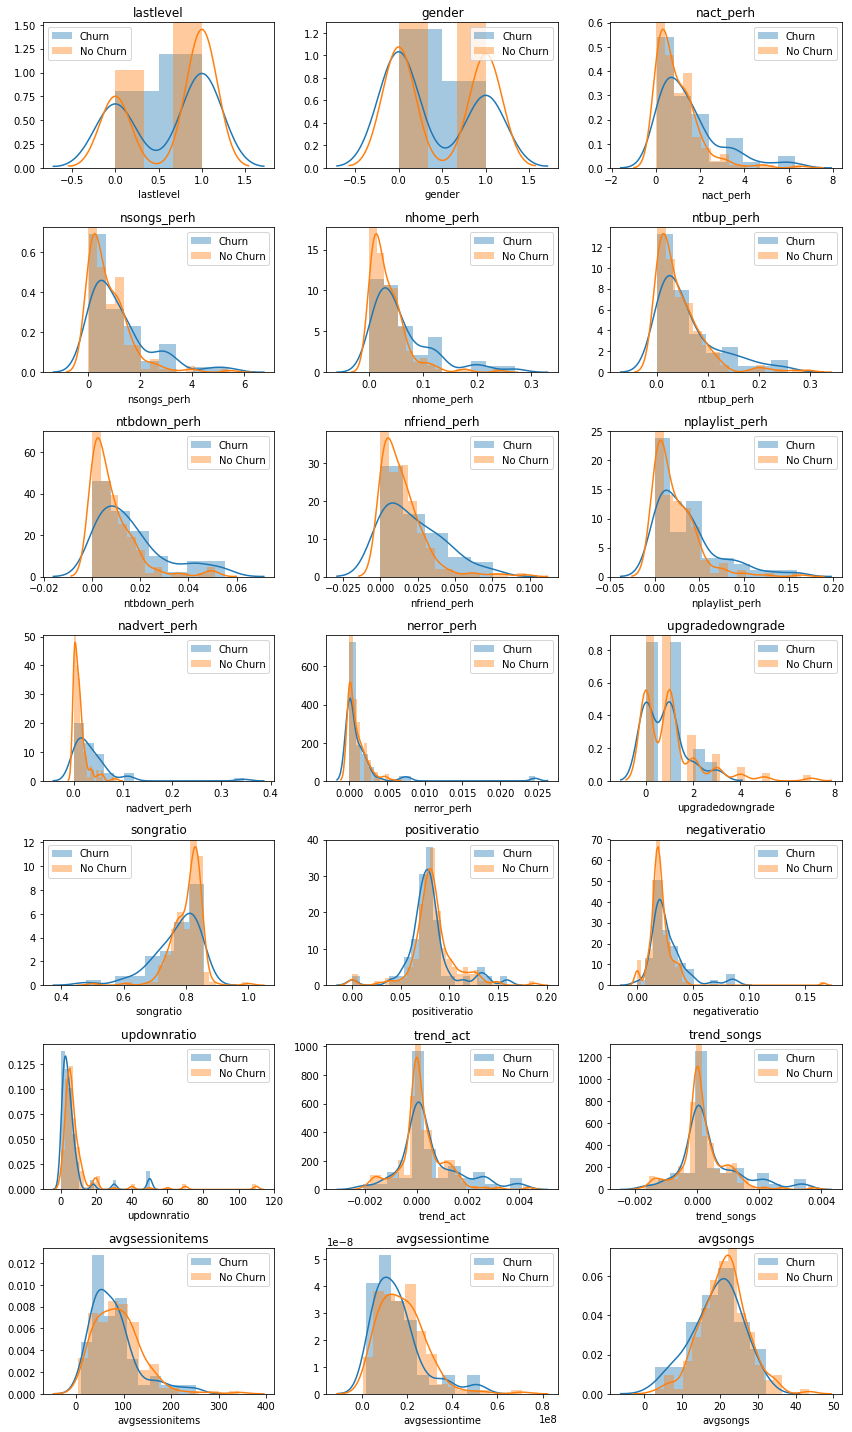

In [97]:
plt.rcParams['figure.figsize'] = (12,20)
col = ['lastlevel', 'gender','nact_perh', 
       'nsongs_perh', 'nhome_perh', 'ntbup_perh',
       'ntbdown_perh', 'nfriend_perh','nplaylist_perh', 
       'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 
       'songratio', 'positiveratio','negativeratio', 
       'updownratio', 'trend_act', 'trend_songs', 
       'avgsessionitems',  'avgsessiontime','avgsongs']
for i in range(21):
    plt.subplot(7,3,i+1)
    plt.title(col[i])
    plt.tight_layout()
    plt.xlabel("")
    sns.distplot(df_user_pd[df_user_pd['label'] == 1][col[i]], norm_hist = True);
    sns.distplot(df_user_pd[df_user_pd['label'] == 0][col[i]], norm_hist = True);
    plt.legend(['Churn','No Churn']);

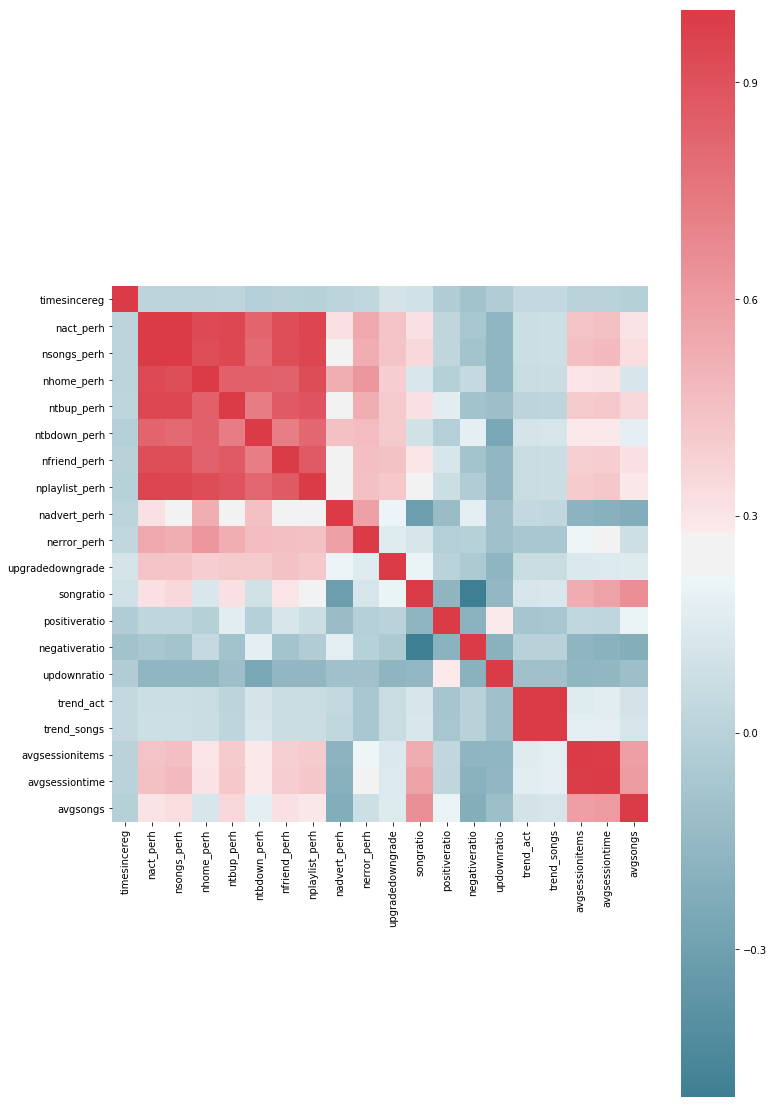

In [123]:
#correlated variables
cormat = df_user_pd[['timesincereg','nact_perh', 'nsongs_perh', 'nhome_perh', 'ntbup_perh','ntbdown_perh', 'nfriend_perh','nplaylist_perh', 
'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio','negativeratio', 
'updownratio', 'trend_act', 'trend_songs', 'avgsessionitems',  'avgsessiontime','avgsongs']].corr()

sns.heatmap(cormat, cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True)

In [73]:
incorrect_records = SparkContext.accumulator(0,0)

In [74]:
incorrect_records.value

0

In [75]:
def add_incorrect_record():
    global incorrect_records
    incorrect_records +=1

In [79]:
#Check if x is the right format
correct_ts = udf(lambda x: 1 if x.isdigit() else add_incorrect_record())

In [138]:
user_log.withColumn('test2',correct_ts(user_log.ts)).show()

In [72]:
incorrect_records.value

0

# Model training

### Pipeline

In [20]:
#Normalizing multiple columns at the same time
numeric_columns = ['timesincereg','nact_perh', 'nsongs_perh', 'nhome_perh', 'ntbup_perh','ntbdown_perh', 'nfriend_perh','nplaylist_perh', 
'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio','negativeratio', 
'updownratio', 'trend_act', 'trend_songs', 'avgsessionitems',  'avgsessiontime','avgsongs']

#Removing correlated variables
numeric_columns = ['timesincereg', 'nsongs_perh', 'ntbup_perh','ntbdown_perh', 'nfriend_perh', 
'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio','negativeratio', 
'updownratio', 'trend_songs', 'avgsessionitems','avgsongs']

numeric_assembler = VectorAssembler(inputCols = numeric_columns, outputCol = "numericvectorized")

scaler = StandardScaler(inputCol = "numericvectorized", outputCol = "numericscaled", withStd = True, withMean = True)
#scaler = Normalizer(inputCol="numericvectorized", outputCol="numericscaled")

binary_columns = ['lastlevel', 'gender']
total_assembler = VectorAssembler(inputCols = binary_columns + ["numericscaled"], outputCol = "features")

# Three classifier that I will tests out, for each define here a pipeline
# Logistic Regression
lr =  LogisticRegression(maxIter = 10, regParam = 0.1)
pipeline1 = Pipeline(stages = [numeric_assembler, scaler, total_assembler, lr])

#
rf = RandomForestClassifier()
pipeline2 = Pipeline(stages = [numeric_assembler, scaler, total_assembler, rf])

#
gb = GBTClassifier()
pipeline3 = Pipeline(stages = [numeric_assembler, scaler, total_assembler, gb])

### Parameter Tuning

In [26]:
#Custom evaluator
class F1score(Evaluator):

    def __init__(self, predictionCol = "prediction", labelCol="label"):
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        """
        Implement F1 score
        """
        tp = dataset.where((dataset.label == 1) & (dataset.prediction == 1)).count()
        fp = dataset.where((dataset.label == 0) & (dataset.prediction == 1)).count()
        tn = dataset.where((dataset.label == 0) & (dataset.prediction == 0)).count()
        fn = dataset.where((dataset.label == 1) & (dataset.prediction == 0)).count()
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        f1 = 2 * precision * recall / (precision + recall)
        
        return f1

    def isLargerBetter(self):
        return True

In [21]:
#
paramGrid1 = ParamGridBuilder() \
.addGrid(lr.maxIter, [10, 30]) \
.addGrid(lr.regParam, [0.0, 0.1, 1]) \
.build()

#.addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \


crossval1 = CrossValidator(estimator = pipeline1,
                          estimatorParamMaps = paramGrid1,
                          evaluator = BinaryClassificationEvaluator(),
                          #Custom evaluator does not work on the cluster, that's why i dont use it here
                          #evaluator = F1score(),
                          numFolds = 4)

# 
paramGrid2 = ParamGridBuilder() \
.addGrid(rf.maxDepth, [6, 7, 8]) \
.addGrid(rf.numTrees, [20, 40, 60]) \
.build()

#.addGrid(rf.maxDepth, [3, 5, 7]) \

crossval2 = CrossValidator(estimator = pipeline2,
                          estimatorParamMaps = paramGrid2,
                          evaluator = BinaryClassificationEvaluator(),
                          #Custom evaluator does not work on the cluster, that's why i dont use it here
                          #evaluator = F1score(),
                          numFolds = 4)

#
paramGrid3 = ParamGridBuilder() \
.addGrid(gb.maxDepth, [3,4]) \
.addGrid(gb.maxIter, [40, 60]) \
.build()

crossval3 = CrossValidator(estimator = pipeline3,
                          estimatorParamMaps = paramGrid3,
                          evaluator = BinaryClassificationEvaluator(),
                          #Custom evaluator does not work on the cluster, that's why i dont use it here
                          #evaluator = F1score(),
                          numFolds = 4)

### Training

In [38]:
a=3

In [22]:
train_plus_val, test = df_user.randomSplit([0.8, 0.2])
#ntotal = df_user.count()
#ntrainval = train_plus_val.count()
#ntest = test.count()

#print(f'Original dataset: {ntotal} rows. Training and validation: {ntrainval} rows. Testing set: {ntest} rows')

In [63]:
#Train logistic regression cross validation 72*150 = 10800s = 3 hours
crossvalmodel1 = crossval1.fit(train_plus_val)

In [29]:
#Train random forest cross validation 36*150 = 4500 seconds = 1.5 hours
crossvalmodel2 = crossval2.fit(train_plus_val)

In [ ]:
#Train gradient boosting 16*500 = 8000 seconds = 2.2 hours
crossvalmodel3 = crossval3.fit(train_plus_val)

### Evaluation

In [64]:
crossvalmodel1.avgMetrics

[0.8053768402725392,
 0.7806771348465291,
 0.7547349113484092,
 0.7948848537467614,
 0.7806771348465291,
 0.7547349113484092]

In [65]:
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel1.getEstimatorParamMaps()]
params

[{'maxIter': 10, 'regParam': 0.0},
 {'maxIter': 10, 'regParam': 0.1},
 {'maxIter': 10, 'regParam': 1.0},
 {'maxIter': 30, 'regParam': 0.0},
 {'maxIter': 30, 'regParam': 0.1},
 {'maxIter': 30, 'regParam': 1.0}]

In [75]:
crossvalmodel1.bestModel.stages[-1]

LogisticRegressionModel: uid = LogisticRegression_1bee873588bf, numClasses = 2, numFeatures = 16

In [66]:
results = crossvalmodel1.transform(test)

In [84]:
results.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|    11|    0|[1.73008804982714...|[0.84942368244562...|       0.0|
|   138|    0|[0.96394091035808...|[0.72391014682241...|       0.0|
|    73|    1|[1.66766333185277...|[0.84126403392393...|       0.0|
|    96|    0|[1.41923819827715...|[0.80521896215184...|       0.0|
|300007|    1|[1.03197067249894...|[0.73729777338625...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [67]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(results)
#gb.featureImportances

0.7727272727272729

In [68]:
evaluator2 = F1score()
evaluator2._evaluate(results)

0.6

In [30]:
crossvalmodel2.avgMetrics

[0.8516857766857766,
 0.8347193784693785,
 0.82131734006734,
 0.8494832901082902,
 0.8387521043771043,
 0.8315312471562472,
 0.8382262944762945,
 0.8377616252616252,
 0.8295446014196015]

In [31]:
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel2.getEstimatorParamMaps()]
params

[{'maxDepth': 6, 'numTrees': 20},
 {'maxDepth': 6, 'numTrees': 40},
 {'maxDepth': 6, 'numTrees': 60},
 {'maxDepth': 7, 'numTrees': 20},
 {'maxDepth': 7, 'numTrees': 40},
 {'maxDepth': 7, 'numTrees': 60},
 {'maxDepth': 8, 'numTrees': 20},
 {'maxDepth': 8, 'numTrees': 40},
 {'maxDepth': 8, 'numTrees': 60}]

In [32]:
importances = crossvalmodel2.bestModel.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]

names = binary_columns + numeric_columns

pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
7,nadvert_perh,0.150497
10,songratio,0.133601
5,ntbdown_perh,0.093127
13,updownratio,0.092852
6,nfriend_perh,0.091692
14,trend_songs,0.076058
3,nsongs_perh,0.057115
12,negativeratio,0.055264
15,avgsessionitems,0.054789
4,ntbup_perh,0.040895


In [33]:
results = crossvalmodel2.transform(test)
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(results)
#gb.featureImportances

0.8116279069767445

In [34]:
evaluator2 = F1score()
evaluator2._evaluate(results)

0.4545454545454545

In [50]:
crossvalmodel3.avgMetrics

[0.7634212229942798,
 0.7459855522074889,
 0.7105274951245815,
 0.7259082760110788]

In [51]:
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel3.getEstimatorParamMaps()]
params

[{'maxDepth': 3, 'maxIter': 20},
 {'maxDepth': 3, 'maxIter': 40},
 {'maxDepth': 5, 'maxIter': 20},
 {'maxDepth': 5, 'maxIter': 40}]

In [52]:
importances = crossvalmodel3.bestModel.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]

names = binary_columns + numeric_columns

pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
7,nadvert_perh,0.184172
6,nfriend_perh,0.157758
5,ntbdown_perh,0.121054
2,timesincereg,0.080150
10,songratio,0.076326
13,updownratio,0.071036
8,nerror_perh,0.059843
14,trend_songs,0.050167
11,positiveratio,0.042764
3,nsongs_perh,0.040222


In [53]:
results = crossvalmodel3.transform(test)
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(results)
#gb.featureImportances

0.734848484848485

In [54]:
evaluator2 = F1score()
evaluator2._evaluate(results)

0.631578947368421

In [79]:
test.show()

+------+---------+------+-------------+-------------+--------------------+-------------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+-----------+-----------+-------------+-------------+--------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+-------------------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------------+--------------------+------------------+-----+
|userId|lastlevel|gender|     obsstart|       obsend|            endstate| registration|nact|nsongs|ntbup|ntbdown|nfriend|nplaylist|ndgrade|nugrade|nhome|nadvert|nhelp|nsettings|nerror|nact_recent|nact_oldest|nsongs_recent|nsongs_oldest|obshours|      timesinc

In [33]:
start = time.time()
pipelinemodel = pipeline1.fit(train_plus_val)

end = time.time()
print(end-start)
#gb.featureImportances

109.29033875465393


In [36]:
start = time.time()
results = pipelinemodel.transform(test)
end = time.time()
print(end-start)

13.639008283615112


In [168]:
#logistic 138
results.show()

+------+---------+------+-------------+-------------+--------------------+-------------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+-----------+-----------+-------------+-------------+--------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|userId|lastlevel|gender|     obsstart|       obsend|            endstate| registration|nact|nsongs|ntbup|ntbdown|nfriend|nplaylist|ndgrade|nu

In [37]:
start = time.time()
results = results.withColumn('tp', when((col('label') == 1) & (col('prediction') == 1), 1).otherwise(0))
results = results.withColumn('fp', when((col('label') == 0) & (col('prediction') == 1), 1).otherwise(0))
results = results.withColumn('tn', when((col('label') == 0) & (col('prediction') == 0), 1).otherwise(0))
results = results.withColumn('fn', when((col('label') == 1) & (col('prediction') == 0), 1).otherwise(0))

tp = results.select(['tp']).agg(Fsum(col('tp'))).collect()[0][0]
fp = results.select(['fp']).agg(Fsum(col('fp'))).collect()[0][0]
tn = results.select(['tn']).agg(Fsum(col('tn'))).collect()[0][0]
fn = results.select(['fn']).agg(Fsum(col('fn'))).collect()[0][0]

precision = tp / (tp + fp)
#In case there are no positive labels
recall = tp / (tp + fn)

print((2 * precision * recall / (precision + recall)))
print(time.time()-start)

0.4
102.94997596740723


In [101]:
results.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|200002|    0|[1.54470921770809...|[0.95645414953586...|       0.0|
|    51|    1|[0.15141561054815...|[0.57513448603699...|       0.0|
|    15|    0|[1.70460634440537...|[0.96799121727304...|       0.0|
|     3|    1|[1.56792824756609...|[0.95834779694141...|       0.0|
|    34|    0|[1.47415123551032...|[0.95018319713391...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [79]:
start = time.time()
tp = results.where((results.label == 1) & (results.prediction == 1)).count()
fp = results.where((results.label == 0) & (results.prediction == 1)).count()
tn = results.where((results.label == 0) & (results.prediction == 0)).count()
fn = results.where((results.label == 1) & (results.prediction == 0)).count()

In [178]:
precision = tp / (tp + fp)
#In case there are no positive labels
recall = tp / (tp + fn)

print((2 * precision * recall / (precision + recall)))
print(time.time()-start)

0.45454545454545453
132.72439455986023


In [83]:
fn

6

In [38]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(results)
#gb.featureImportances

0.8674242424242424

In [180]:
importances = pipelinemodel.stages[-1].featureImportances

In [181]:
importances_list = [importances[i] for i in range(len(importances))]

In [182]:
names = binary_columns + numeric_columns

In [183]:
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
6,nfriend_perh,0.162942
7,nadvert_perh,0.136832
5,ntbdown_perh,0.086703
4,ntbup_perh,0.083354
10,songratio,0.082699
13,updownratio,0.064653
8,nerror_perh,0.062639
15,avgsessionitems,0.050720
3,nsongs_perh,0.048776
12,negativeratio,0.043295


Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Appendix

In [343]:
df_user2 = numeric_assembler.transform(df_user)
df_user2.select(['numericvectorized']).head()

Row(numericvectorized=DenseVector([0.2603, 0.1878, 0.0075, 0.0116, 0.0034, 0.0027, 0.0048, 0.0355, 0.0, 0.0, 0.7218, 0.0735, 0.0184, 3.3333, -0.0, -0.0, 54.4286, 9269000.0, 22.9167]))

In [344]:
sceler = scaler.fit(df_user2)
df_user2 = sceler.transform(df_user2)
df_user2.select(['numericvectorized','numericscaled']).head()

Row(numericvectorized=DenseVector([0.2603, 0.1878, 0.0075, 0.0116, 0.0034, 0.0027, 0.0048, 0.0355, 0.0, 0.0, 0.7218, 0.0735, 0.0184, 3.3333, -0.0, -0.0, 54.4286, 9269000.0, 22.9167]), numericscaled=DenseVector([-0.7246, -0.7372, -0.7589, -0.6842, -0.5811, -0.8125, -0.7389, 0.6034, -0.5009, -0.8142, -1.2659, -0.3804, -0.2818, -0.3844, -0.2851, -0.2943, -0.6345, -0.758, 0.3593]))

In [345]:
#All three are dense vectors
df_user2 = total_assembler.transform(df_user2)
df_user2.select(['numericvectorized','numericscaled','features']).head()

Row(numericvectorized=DenseVector([0.2603, 0.1878, 0.0075, 0.0116, 0.0034, 0.0027, 0.0048, 0.0355, 0.0, 0.0, 0.7218, 0.0735, 0.0184, 3.3333, -0.0, -0.0, 54.4286, 9269000.0, 22.9167]), numericscaled=DenseVector([-0.7246, -0.7372, -0.7589, -0.6842, -0.5811, -0.8125, -0.7389, 0.6034, -0.5009, -0.8142, -1.2659, -0.3804, -0.2818, -0.3844, -0.2851, -0.2943, -0.6345, -0.758, 0.3593]), features=DenseVector([0.0, 1.0, -0.7246, -0.7372, -0.7589, -0.6842, -0.5811, -0.8125, -0.7389, 0.6034, -0.5009, -0.8142, -1.2659, -0.3804, -0.2818, -0.3844, -0.2851, -0.2943, -0.6345, -0.758, 0.3593]))

In [61]:
sc.version

NameError: name 'sc' is not defined

In [62]:
spark.sparkContext.version

'2.4.3'

Conclusions

Areas of improvement:
- optimize the data wrangling and feature engineering to scale the model - it took long time to train, in the limited amount of time was unable to run large scale cross validation on the AWS cloud, constrained also by the self-imposed budget 
- looking closely in some of the patterns in the user activity from which i could gain additional insights beyond just number of songs per unit of time, or average number of logs per session, I could also analyze average time listening to music, analyzing exact times to identify users who skip songs, listen only partially, or all sorts of different user beheaviors that could help understand 